# exp002

In [5]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_log_error
import lightgbm as lgb

sns.set_style("darkgrid")
%matplotlib inline

## データセットの読み込み

In [6]:
input_path = Path("../input")

train_df = pd.read_parquet(input_path / "train.parquet")
test_df = pd.read_parquet(input_path / "test.parquet")

## RMSLEの定義

In [18]:
def feval_rmsle(preds, data):
    y_true = data.get_label()
    preds = np.clip(preds, 0, None)  # 0より小さい値を0に置換
    rmsle = np.sqrt(mean_squared_log_error(y_true, preds))
    return 'RMSLE', rmsle, False

## train

In [19]:
def train(df, model_path):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_rmsles = []

    for fold, (train_index, valid_index) in enumerate(kf.split(df)):
        print(f"start training for fold {fold}")

        X_train = df.iloc[train_index].drop(["count", "datetime", "casual", "registered"], axis=1)
        y_train = df.iloc[train_index]["count"]

        X_valid = df.iloc[valid_index].drop(["count", "datetime", "casual", "registered"], axis=1)
        y_valid = df.iloc[valid_index]["count"]

        print("start training")
        params = {
            "objective": "regression",
            "seed": 42,
            "learning_rate": 0.05,
            "num_leaves": 32,
        }

        train_set = lgb.Dataset(X_train, y_train)
        valid_set = lgb.Dataset(X_valid, y_valid, reference=train_set)

        model = lgb.train(
            params=params,
            train_set=train_set,
            valid_sets=[train_set, valid_set],
            num_boost_round=10000,
            feval=feval_rmsle,
            callbacks=[
                lgb.early_stopping(stopping_rounds=10, verbose=True),
                lgb.log_evaluation(period=10)
            ]
        )

        print(f"predict valid for fold {fold}")
        y_pred = model.predict(X_valid)

        fold_rmsles.append(np.sqrt(mean_squared_log_error(y_valid, y_pred)))

        print(f"save model for fold {fold}")
        model.save_model(model_path / f"model_fold{fold+1:03d}.bin", num_iteration=model.best_iteration)

    return sum(fold_rmsles) / len(fold_rmsles)

In [20]:
model_path = Path("../output/model002")

train_rmsle = train(train_df, model_path)
print(f"RMSLE: {train_rmsle}")

start training for fold 0
start training
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 227
[LightGBM] [Info] Number of data points in the train set: 8708, number of used features: 8
[LightGBM] [Info] Start training from score 191.584750
Training until validation scores don't improve for 10 rounds
[10]	training's l2: 25732	training's RMSLE: 1.46767	valid_1's l2: 26078.8	valid_1's RMSLE: 1.48843
[20]	training's l2: 22854.5	training's RMSLE: 1.40697	valid_1's l2: 23320.1	valid_1's RMSLE: 1.42752
[30]	training's l2: 21451.2	training's RMSLE: 1.36495	valid_1's l2: 22149.8	valid_1's RMSLE: 1.38776
[40]	training's l2: 20626.7	training's RMSLE: 1.33564	valid_1's l2: 21576.2	valid_1's RMSLE: 1.36209
[50]	training's l2: 20108.2	training's RMSLE: 1.31491	valid_1's l2: 21296.2	valid_1's RMSLE

## evaluate

In [21]:
def evaluate(df, model_path):
    predictions = []

    for fold in range(5):
        print(f"loading model for fold {fold}")
        model = lgb.Booster(model_file=model_path / f"model_fold{fold+1:03d}.bin")

        print(f"start evaluate for fold {fold}")
        X_test = df.drop(["datetime"], axis=1)

        print(f"predict test for fold {fold}")
        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        predictions.append(y_pred)
    
    average_predictions = np.mean(predictions, axis=0)
    return average_predictions

In [22]:
y_pred = evaluate(test_df, model_path)
y_pred

loading model for fold 0
start evaluate for fold 0
predict test for fold 0
loading model for fold 1
start evaluate for fold 1
predict test for fold 1
loading model for fold 2
start evaluate for fold 2
predict test for fold 2
loading model for fold 3
start evaluate for fold 3
predict test for fold 3
loading model for fold 4
start evaluate for fold 4
predict test for fold 4


array([111.9512672 ,  72.12340128,  72.12340128, ...,  94.42352578,
        89.32561831,  80.54186058])

In [23]:
submission = pd.read_csv(input_path / "sampleSubmission.csv")
submission["count"] = y_pred
submission.to_csv("../output/submission002.csv", index=False)

## Result

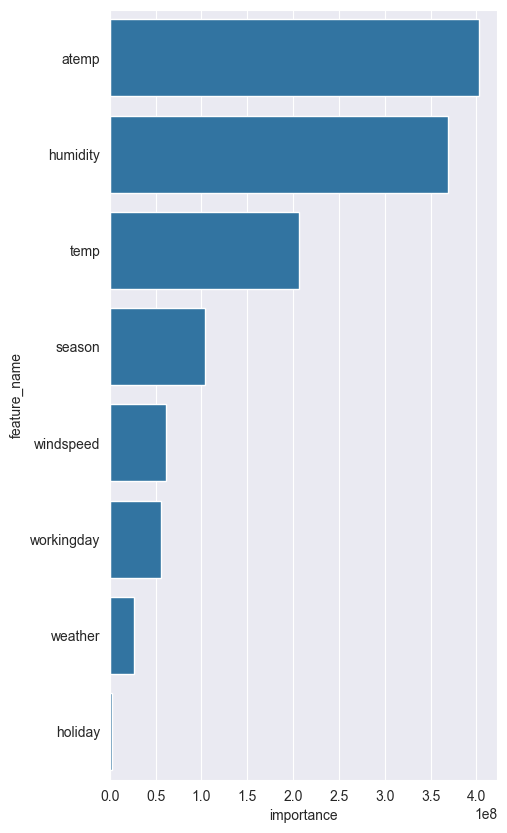

In [24]:
model = lgb.Booster(model_file=model_path / f"model_fold001.bin")
importance_df = pd.DataFrame()

importance_df["importance"] = model.feature_importance(importance_type="gain")
importance_df["feature_name"] = model.feature_name()
importance_df = importance_df.sort_values("importance", ascending=False)

fig = plt.figure(figsize=(5, 10))
sns.barplot(data=importance_df, x="importance", y="feature_name")
plt.show()